# Example of Dataflow pipeline

This notebooks shows how you can use Dataflow to do distributed data processing.
In this case, the processing involves computing a statistical fit, something that is hard to do in SQL,
but quite straightforward in Python.

## Install Dataflow

In [1]:
%pip install --upgrade --quiet 'apache-beam[gcp]'

Note: you may need to restart the kernel to use updated packages.


After doing the pip install (above), please restart your kernel.

## Fit rides at a single station to a Gamma distribution

In [1]:
# CHANGE THIS to try this notebook out
PROJECT='cloud-training-demos' 
# London Bicycles is in EU, so process it in EU and make sure bucket is in EU
BUCKET='cloud-training-demos-eu'
REGION='europe-west1'

Let's get the duration of all the rides in a station

In [2]:
from google.cloud import bigquery
bq = bigquery.Client(project=PROJECT)
query = """
SELECT duration
FrOM `bigquery-public-data.london_bicycles.cycle_hire`
WHERE start_station_id = 708
"""
df = bq.query(query, location='EU').to_dataframe()
print(df.describe())

            duration
count   19112.000000
mean     1621.541440
std      8781.210736
min         0.000000
25%       360.000000
50%       720.000000
75%      1260.000000
max    687360.000000


Let's plot the distribution of these rides

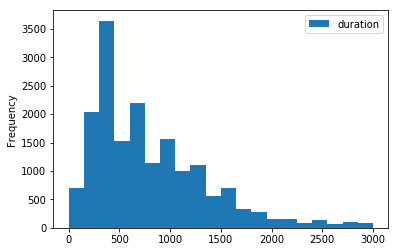

In [3]:
ax = df.plot.hist(range=[0, 3000], bins=20);

Fit to a Gamma distribution

In [4]:
from scipy import stats
ag,bg,cg = stats.gamma.fit(df['duration'])
print(ag, bg, cg)

7.297838862149757e-06 -6.485566100418746e-16 4.234333701782285


## The Beam/Dataflow pipeline to do this at scale

In [5]:
%%writefile requirements.txt
numpy
scipy

Overwriting requirements.txt


In [ ]:
# output dataset
!bq --location=EU mk --dataset ch05eu

In [7]:
import apache_beam as beam
import logging
import datetime, os

def compute_fit(row):
  from scipy import stats
  import numpy as np
  durations = row['duration_array']
  ag, bg, cg = stats.gamma.fit(durations)
  if np.isfinite(ag) and np.isfinite(bg) and np.isfinite(cg):
      result = {}
      result['station_id'] = str(row['start_station_id'])
      result['ag'] = ag
      result['bg'] = bg
      result['cg'] = cg
      yield result

def run_job(in_test_mode=True):
  import shutil, os, subprocess
  job_name = 'computestats' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
  
  if in_test_mode:
      print('Launching local job ... hang on')
      OUTPUT_DIR = './station_stats'
      shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
      os.makedirs(OUTPUT_DIR)
  else:
      print('Launching Dataflow job {} ... hang on'.format(job_name))
      OUTPUT_DIR = 'gs://{0}/station_stats'.format(BUCKET)
      try:
        subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
      except:
        pass
      
  options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'region': REGION,
      'teardown_policy': 'TEARDOWN_ALWAYS',
      'no_save_main_session': True,
      'requirements_file': 'requirements.txt'
  }
  opts = beam.pipeline.PipelineOptions(flags = [], **options)
  if in_test_mode:
      RUNNER = 'DirectRunner'
  else:
      RUNNER = 'DataflowRunner'
  
  if in_test_mode:
    query = """
      SELECT start_station_id, ARRAY_AGG(duration) AS duration_array
      FROM `bigquery-public-data.london_bicycles.cycle_hire`
      WHERE start_station_id BETWEEN 700 AND 710
      GROUP BY start_station_id
      """
  else:
     query = """
      SELECT start_station_id, ARRAY_AGG(duration) AS duration_array
      FROM `bigquery-public-data.london_bicycles.cycle_hire`
      GROUP BY start_station_id
      """

  with beam.Pipeline(RUNNER, options = opts) as p:
    (p 
      | 'read_bq' >> beam.io.Read(beam.io.BigQuerySource(query=query, use_standard_sql=True))
      | 'compute_fit' >> beam.FlatMap(compute_fit)
      | 'write_bq' >> beam.io.gcp.bigquery.WriteToBigQuery(
          'ch05eu.station_stats', schema='station_id:string,ag:FLOAT64,bg:FLOAT64,cg:FLOAT64')
    )
    
run_job(in_test_mode = False)
print('Done')

Launching Dataflow job computestats-190606-212218 ... hang on


/home/jupyter/.local/lib/python3.5/site-packages/apache_beam/runners/dataflow/dataflow_runner.py:680: BeamDeprecationWarning: BigQuerySink is deprecated since 2.11.0. Use WriteToBigQuery instead.
  kms_key=transform.kms_key))


Done


## Verify output table

In [8]:
%%bigquery stations
SELECT * from ch05eu.station_stats

In [9]:
stats = stations.describe()
stats

,ag,bg,cg
count,8.100000e+02,8.100000e+02,8.100000e+02
mean,2.799379e+00,-1.911546e+08,5.733028e+05
std,2.417705e+01,5.037746e+09,1.428073e+07
min,6.789745e-07,-1.431073e+11,1.557510e+00
25%,3.521553e-06,-4.231209e-15,4.163213e+00
50%,6.568865e-06,-1.174398e-17,4.282817e+00
75%,1.277219e-05,-1.001521e-19,4.499690e+00
max,3.532822e+02,4.705682e+02,4.045320e+08


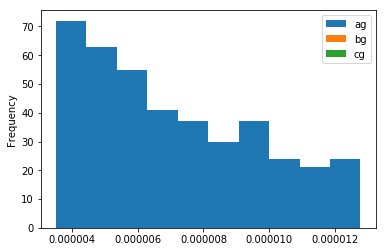

In [10]:
stations.plot.hist('ag', range=[stats['ag']['25%'], stats['ag']['75%']]);

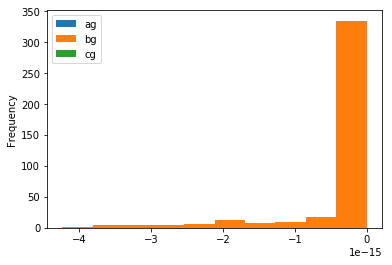

In [11]:
stations.plot.hist('bg', range=[stats['bg']['25%'], stats['bg']['75%']]);

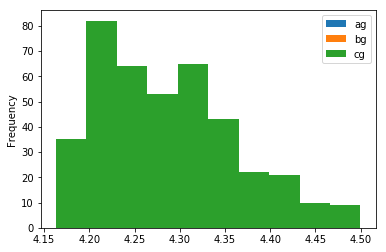

In [12]:
stations.plot.hist('cg', range=[stats['cg']['25%'], stats['cg']['75%']]);

(4.163213176566146, 4.49969023901715)

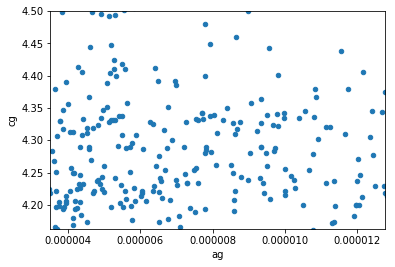

In [13]:
ax = stations.plot.scatter('ag', 'cg');
ax.set_xlim(stats['ag']['25%'], stats['ag']['75%'])
ax.set_ylim(stats['cg']['25%'], stats['cg']['75%'])

Copyright Google Inc. 2019 Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.